# AutoInland Vehicle Insurance Claim Challenge - Group 24

### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

### Read files

In [ ]:
# Load files into a pandas dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')

### Exploratory Data Analysis

In [ ]:
print(train.corr())
# Preview the first five rows of the train set
train.head()

             Age    No_Pol    target
Age     1.000000  0.016226 -0.028937
No_Pol  0.016226  1.000000  0.074245
target -0.028937  0.074245  1.000000


,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [ ]:
# Preview the first five rows of the test set
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [ ]:
# Preview the first five rows of the sample submission file
ss.head()

,ID,target
0,ID_01QM0NU,0
1,ID_024NJLZ,0
2,ID_02NOVWQ,0
3,ID_02VSP68,0
4,ID_02YB37K,0


In [ ]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (12079, 14)
The shape of the test set is: (1202, 13)


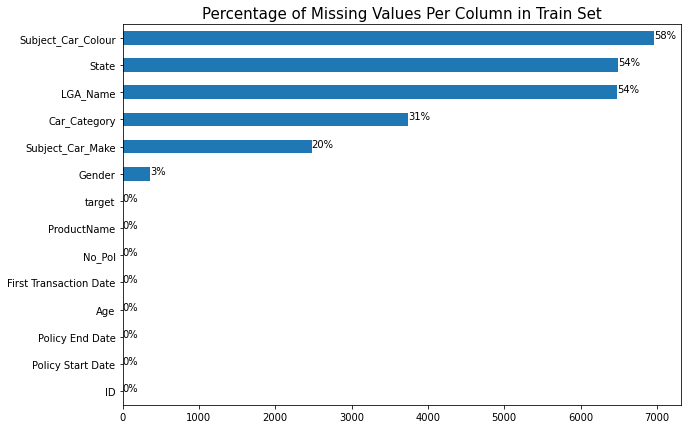

In [ ]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

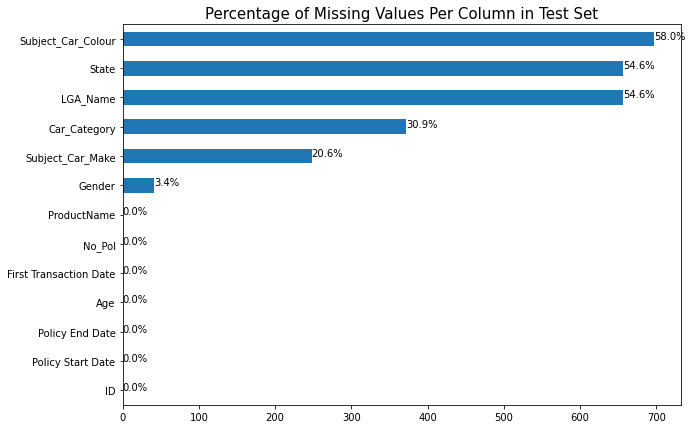

In [ ]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

## Combine train and test sets for easy preprocessing 

---



In [ ]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (13281, 14)


In [ ]:
all_data.drop('State', inplace=True, axis = 1)
#all_data.drop('LGA_Name', inplace=True, axis = 1)

# Preview the last five rows of the combined dataframe
all_data.tail()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,ProductName,target
13276,ID_ZTTHC5X,2010-12-05,2011-12-04,Male,67,2010-12-05,2,JEEP,Black,TOYOTA,Victoria Island,Car Classic,NaN
13277,ID_ZUJAFUP,2010-01-14,2011-01-13,Male,43,2010-01-14,1,Saloon,Silver,Hyundai,Surulere,Car Classic,NaN
13278,ID_ZWHCTUM,2010-07-26,2011-07-25,Male,30,2010-07-26,1,Truck,White,Iveco,Victoria Island,CVTP,NaN
13279,ID_ZWQRL8L,2010-02-16,2011-02-15,Male,44,2010-02-16,2,Saloon,NaN,Nissan,Aba North,Car Classic,NaN
13280,ID_ZWZ92GU,2010-03-18,2011-03-17,Male,28,2010-03-18,1,Saloon,Silver,TOYOTA,NaN,Car Classic,NaN


In [ ]:
# Check the column names and datatypes
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      13281 non-null  object 
 1   Policy Start Date       13281 non-null  object 
 2   Policy End Date         13281 non-null  object 
 3   Gender                  12881 non-null  object 
 4   Age                     13281 non-null  int64  
 5   First Transaction Date  13281 non-null  object 
 6   No_Pol                  13281 non-null  int64  
 7   Car_Category            9171 non-null   object 
 8   Subject_Car_Colour      5622 non-null   object 
 9   Subject_Car_Make        10557 non-null  object 
 10  LGA_Name                6149 non-null   object 
 11  ProductName             13281 non-null  object 
 12  target                  12079 non-null  float64
dtypes: float64(1), int64(2), object(10)
memory usage: 1.3+ MB


In [ ]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  12881 non-null  category      
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            9171 non-null   category      
 8   Subject_Car_Colour      5622 non-null   category      
 9   Subject_Car_Make        10557 non-null  category      
 10  LGA_Name                6149 non-null   category      
 11  ProductName             13281 non-null  category      
 12  target                  12079 non-null  float6

### Distribution of the target variable

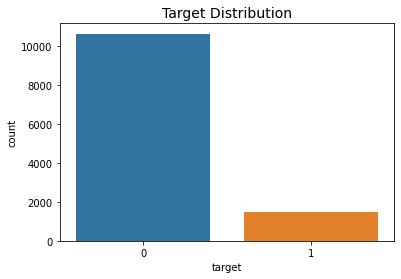

In [ ]:
sns.countplot(train.target)
plt.title('Target Distribution', fontdict={'size':14});

### Distribution of the Gender column

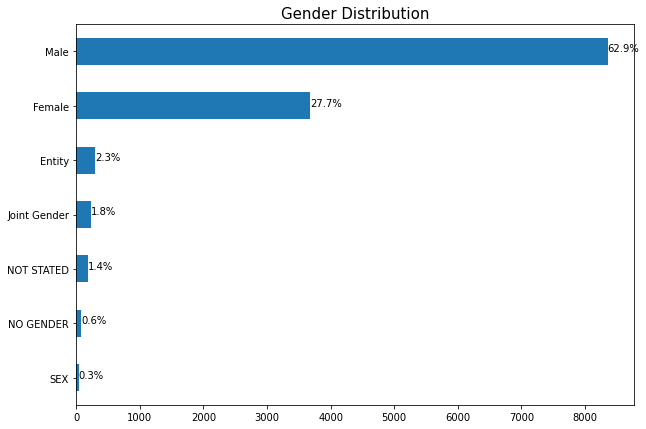

In [ ]:
# Gender distribution 
ax = all_data.Gender.value_counts().sort_values().plot(kind = 'barh', figsize=(10,7))
plt.title('Gender Distribution', fontdict={'size': 15})
for p in ax.patches:
  percentage ='{:,.1f}%'.format((p.get_width()/all_data.shape[0])*100)
  width, height =p.get_width(),p.get_height()
  x=p.get_x()+width+0.02
  y=p.get_y()+height/2
  ax.annotate(percentage,(x,y))

In [ ]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

Male      8356
Female    3679
Other      846
Name: Gender, dtype: int64

### Number of unique values per categorical column

In [ ]:
# Check unique values for each categorical column
for col in cat_cols:
  print(col)
  print(all_data[col].unique(), '\n')

Gender
['Male', 'Female', 'Other', NaN]
Categories (3, object): ['Other', 'Female', 'Male'] 

Car_Category
['Saloon', 'JEEP', NaN, 'Motorcycle', 'Truck', ..., 'Wagon', 'Shape Of Vehicle Chasis', 'Sedan', 'Station 4 Wheel', 'Tipper Truck']
Length: 17
Categories (16, object): ['Bus', 'CAMRY CAR HIRE', 'JEEP', 'Mini Bus', ..., 'Tipper Truck', 'Truck', 'Van', 'Wagon'] 

Subject_Car_Colour
['Black', 'Grey', 'Red', NaN, 'As Attached', ..., 'Yellow & White', 'Beige Mitalic', 'Light Gray', 'Blue Sky', 'Red Maroon']
Length: 47
Categories (46, object): ['As Attached', 'Ash', 'B.Silver', 'Beige Mitalic', ..., 'White & Yellow', 'Wine', 'Yellow', 'Yellow & White'] 

Subject_Car_Make
['TOYOTA', NaN, 'REXTON', 'Lexus', 'Hyundai', ..., 'BRILLIANCE', 'Buik', 'COMMANDER', 'Bajaj', 'Datsun']
Length: 76
Categories (75, object): ['.', 'ABG', 'ACURA', 'As Attached', ..., 'Volvo', 'Wrangler Jeep', 'Yamaha', 'ZOYTE'] 

LGA_Name
[NaN, 'Lagos', 'Ikeja', 'Badagry', 'Eti-Osa', ..., 'Hong', 'Ifako-Agege', 'Benue',

### Filling in missing values

In [ ]:
# Fill in missing values
# For cat cols and date cols fill in with mode and for num cols fill in with 9999
for col in all_data.columns:
  if col in date_cols+cat_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
  elif col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(9999)) # numerical columns were non-null columns

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum()

Age                       0
Car_Category              0
First Transaction Date    0
Gender                    0
ID                        0
LGA_Name                  0
No_Pol                    0
Policy End Date           0
Policy Start Date         0
ProductName               0
Subject_Car_Colour        0
Subject_Car_Make          0
dtype: int64

### Feature Engineering

In [ ]:
# Extract date features from the date columns
for col in date_cols:
  for date_feature in ['year', 'month', 'day']:
    all_data[col+date_feature] = getattr(all_data[col].dt, date_feature)

all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy End Dateyear,Policy End Datemonth,Policy End Dateday,First Transaction Dateyear,First Transaction Datemonth,First Transaction Dateday
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,0.0,2010,5,14,2011,5,13,2010,5,14
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,1.0,2010,11,29,2011,11,28,2010,11,29
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,...,0.0,2010,3,21,2011,3,20,2010,3,21
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,Saloon,Black,TOYOTA,...,0.0,2010,8,21,2011,8,20,2010,8,21
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Saloon,Black,TOYOTA,...,1.0,2010,8,29,2010,12,31,2010,8,29


#### Dealing with categorical variables

In [ ]:
# Encode categorical features
all_data = pd.get_dummies(data = all_data, columns = cat_cols)
all_data.head()

,ID,Policy Start Date,Policy End Date,Age,First Transaction Date,No_Pol,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,...,LGA_Name_kumbotso,ProductName_CVTP,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
0,ID_0040R73,2010-05-14,2011-05-13,30,2010-05-14,1,0.0,2010,5,14,...,0,0,1,0,0,0,0,0,0,0
1,ID_0046BNK,2010-11-29,2011-11-28,79,2010-11-29,1,1.0,2010,11,29,...,0,0,1,0,0,0,0,0,0,0
2,ID_005QMC3,2010-03-21,2011-03-20,43,2010-03-21,1,0.0,2010,3,21,...,0,0,1,0,0,0,0,0,0,0
3,ID_0079OHW,2010-08-21,2011-08-20,2,2010-08-21,1,0.0,2010,8,21,...,0,0,0,0,0,0,1,0,0,0
4,ID_00BRP63,2010-08-29,2010-12-31,20,2010-08-29,3,1.0,2010,8,29,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Change columns names ([LightGBM] Do not support special JSON characters in feature name.)
import re
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in all_data.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
all_data_renamed = all_data.rename(columns=new_names)
np.unique(all_data_renamed.dtypes)

array([dtype('uint8'), dtype('<M8[ns]'), dtype('uint8'), dtype('int64'),
       dtype('float64'), dtype('O')], dtype=object)

In [ ]:
# View the columns with 'datetime' data types
columns_to_drop = all_data_renamed.select_dtypes(include=['datetime64'])
columns_to_drop

,PolicyStartDate,PolicyEndDate,FirstTransactionDate
0,2010-05-14,2011-05-13,2010-05-14
1,2010-11-29,2011-11-28,2010-11-29
2,2010-03-21,2011-03-20,2010-03-21
3,2010-08-21,2011-08-20,2010-08-21
4,2010-08-29,2010-12-31,2010-08-29
...,...,...,...
13276,2010-12-05,2011-12-04,2010-12-05
13277,2010-01-14,2011-01-13,2010-01-14
13278,2010-07-26,2011-07-25,2010-07-26
13279,2010-02-16,2011-02-15,2010-02-16


In [ ]:
# Exclude the data columns due to their data types
# Separate train and test data from the combined dataframe
train_df = all_data_renamed[:ntrain].drop(columns=columns_to_drop)
test_df = all_data_renamed[ntrain:].drop(columns=columns_to_drop)

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((12079, 432), (1202, 432))

In [ ]:
# Minimum age for driving in Nigeria is 18
# View columns that have age less than 18
train_df[train_df['Age'] < 18]

# The rows could be replaced with the minimum age for driving a car - 18

train_df['Age'] = np.where(train_df['Age'] < 18, 18, train_df['Age'])
train_df[train_df['Age'] < 18]

,ID,Age,No_Pol,target,PolicyStartDateyear,PolicyStartDatemonth,PolicyStartDateday,PolicyEndDateyear,PolicyEndDatemonth,PolicyEndDateday,...,LGA_Name_kumbotso,ProductName_CVTP,ProductName_CarClassic,ProductName_CarPlus,ProductName_CarVintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_CustomizedMotor,ProductName_MotorCycle,ProductName_Muuve


## Training and making predictions



In [ ]:
# Select main columns to be used in training
main_cols = train_df.columns.difference(['ID', 'target'])

#print(train_df.corr())

X = train_df[main_cols]
y = train_df.target

# SMOTE Oversampling dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Random Undersampling dataset
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled = rus.fit_resample(X, y)

# Random Oversampling dataset
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=0)
# X_resampled, y_resampled = ros.fit_resample(X, y)

# ADASYN Oversampling dataset
# from imblearn.over_sampling import ADASYN
# sm = ADASYN(random_state=0)
# X_resampled, y_resampled = sm.fit_resample(X, y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size=0.3, random_state=42)

# Train model
model = LGBMClassifier() # 0.91
#model = svm.SVC(kernel='linear')
#model = RandomForestClassifier(max_depth=150, n_estimators=80, max_features=1, random_state = 42) # 0.90  # 0.94  # 0.93
#model = DecisionTreeClassifier(max_depth=100) #0.88   # 0.91
#model = MLPClassifier(alpha=1, max_iter=1000) #0.74   # 0.29

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

F1 score on the X_test is: 0.9104933311907439


### Making predictions of the test set and creating a submission file

<class 'numpy.ndarray'> 61.0
[0.87038891 0.90497435 0.91998223 0.90980392 0.88467155]


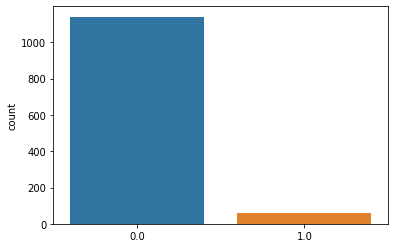

In [ ]:
# Make prediction on the test set
test_df = test_df[main_cols]
predictions = model.predict(test_df)

print(type(predictions), sum(predictions))

# Create a submission file
# sub_file = ss.copy()
# sub_file.predictions = predictions
array = []
id_column = test['ID']

for i in range(len(id_column)):
    array.append([id_column[i], int(predictions[i])])
    
#print(array[0])
    
    
sub_file = pd.DataFrame(array, columns =["ID", "target"] )

# Check the distribution of your predictions
sns.countplot(predictions);

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_test, y_test, cv=5, scoring='f1_macro')

print(scores)

In [ ]:
# Create a csv file and upload to zindi 
sub_file.to_csv('SampleSubmission.csv', index = False)